# Poland 2019 EP elections doctoring quick check 

This is a brief adaptation of the notebook hosted at https://github.com/brezniczky/ep_elections_2019_hun/
(rendered version: [Poland 2019 EP Elections](https://htmlpreview.github.io/?https://github.com/brezniczky/ep_elections_2019_hun/blob/master/Poland%202019%20EP%20Elections.html)) partly to demonstrate the use of the DrDigit package (see https://github.com/brezniczky/drdigit/), in expectation of the coincident 13 October 2019 elections in Hungary as well as in Poland.

The author is much more an enthusiast than an analyst, it's a best effort.

[Contributions](https://github.com/brezniczky/drdigit/issues/1) are welcome.
I probably do not have a good intuition of what fits the bill politically in today's Poland - opinions as well as more data might come useful!

There might be some relatively simple explanation of why there seems to be a systematic change in the results for the more suspicious areas. I have reasons to believe that socio-economic status of the vote counters is ruled out more than not, but you never know, that could be just the most plausible option.

In [1]:
!pip install -U pip
!pip install drdigit-brezniczky==0.0.12

     |████████████████████████████████| 1.4MB 3.4MB/s 
  Found existing installation: pip 19.2.2
    Uninstalling pip-19.2.2:
      Successfully uninstalled pip-19.2.2


In [2]:
from collections import OrderedDict
import numpy.random as rnd
import pandas as pd
import matplotlib.pyplot as plt
import drdigit as drd
import poland_2019_ep_preprocessing as pp

# I keep this commented out and uncomment it before committing
drd.set_option(physical_cache_path="")  # as IMHO Kaggle dislikes joblib

Now that the package is available, it is time for some processing.

# Preprocessing

In [3]:
df, info = pp.get_preprocessed_data()

Merging "lista" columns...


In [4]:
print(df.columns)

Index(['Kod terytorialny gminy',
       'Lista nr 1 - KWW KONFEDERACJA KORWIN BRAUN LIROY NARODOWCY',
       'Lista nr 2 - KW WIOSNA ROBERTA BIEDRONIA',
       'Lista nr 3 - KKW KOALICJA EUROPEJSKA PO PSL SLD .N ZIELONI',
       'Lista nr 4 - KW PRAWO I SPRAWIEDLIWOŚĆ',
       'Lista nr 5 - KKW LEWICA RAZEM - RAZEM, UNIA PRACY, RSS',
       'Lista nr 6 - KWW KUKIZ'15',
       'Lista nr 7 - KWW POLSKA FAIR PLAY BEZPARTYJNI GWIAZDOWSKI',
       'Lista nr 9 - KKW POLEXIT - KOALICJA',
       'Lista nr 10 - KW JEDNOŚĆ NARODU', 'Liczba kart ważnych',
       'Liczba wyborców uprawnionych do głosowania',
       'ld_Lista nr 1 - KWW KONFEDERACJA KORWIN BRAUN LIROY NARODOWCY',
       'ld_Lista nr 2 - KW WIOSNA ROBERTA BIEDRONIA',
       'ld_Lista nr 3 - KKW KOALICJA EUROPEJSKA PO PSL SLD .N ZIELONI',
       'ld_Lista nr 4 - KW PRAWO I SPRAWIEDLIWOŚĆ',
       'ld_Lista nr 5 - KKW LEWICA RAZEM - RAZEM, UNIA PRACY, RSS',
       'ld_Lista nr 6 - KWW KUKIZ'15',
       'ld_Lista nr 7 - KWW POLSKA FAIR

In [5]:
print(info)

MergedDataInfo(
    valid_votes_column: Liczba kart ważnych,
    nr_of_registered_voters_column: Liczba wyborców uprawnionych do głosowania,
    lista_columns: Lista nr 1 - KWW KONFEDERACJA KORWIN BRAUN LIROY NARODOWCY, Lista nr 2 - KW WIOSNA ROBERTA BIEDRONIA, Lista nr 3 - KKW KOALICJA EUROPEJSKA PO PSL SLD .N ZIELONI, Lista nr 4 - KW PRAWO I SPRAWIEDLIWOŚĆ, Lista nr 5 - KKW LEWICA RAZEM - RAZEM, UNIA PRACY, RSS, Lista nr 6 - KWW KUKIZ'15, Lista nr 7 - KWW POLSKA FAIR PLAY BEZPARTYJNI GWIAZDOWSKI, Lista nr 9 - KKW POLEXIT - KOALICJA, Lista nr 10 - KW JEDNOŚĆ NARODU
)


In [6]:
df["ld_" + info.get_lista_column(4)].iloc[:5]

0    7
1    1
2    2
3    2
4    5
Name: ld_Lista nr 4 - KW PRAWO I SPRAWIEDLIWOŚĆ, dtype: int64

In [7]:
df[info.get_lista_column(4)].iloc[:5]

0    247
1     61
2     62
3    352
4    215
Name: Lista nr 4 - KW PRAWO I SPRAWIEDLIWOŚĆ, dtype: int64

# 1. Initial exploration

The two major Listas in Poland are Lista 3 and 4.

Lista 4 digits were found to be more problematic on overall assessments.

These can be played with via the (hyper)parameters, below is one way to come to considering raising the eyebrows for the Lista 4 results.

In [8]:
# to fix the smooth filtering
rnd.seed(1234)

tests = OrderedDict()

# p-values for Lista 4 filtered per ward, MIN_N_WARDS = 0
# 100: 0.0746
# 200: 0.0172
# 300: 0.0426

# minimum number of party-specific votes to require 
# per each row/each ward in a municipality
MIN_VOTE_LIMIT = 100
# minimum electoral wards to require per municipality
MIN_N_WARDS = 0
# number of simulation iterations - increase to get smoother CDFs
LL_ITERATIONS = 5000

for feasibility in ["municipality", "ward"]:
    for lista in [3, 4]:
        if feasibility == "ward":
            feasible_df = drd.get_feasible_rows(
                df, MIN_VOTE_LIMIT,
                [list(df.columns).index(
                    info.get_lista_column(lista))]
            )
        else:
            # I promise this filter will change :)
            groups = drd.get_feasible_groups(
                df, min_n_wards=MIN_N_WARDS,
                min_votes=MIN_VOTE_LIMIT,
                value_colname=info.get_lista_column(lista),
                group_colname=info.area_column,
            )
            feasible_df = df[df[info.area_column].isin(groups)]
        
        print("Lista %d, by %s, nr of municipalities: %d" % 
              (lista, feasibility, len(feasible_df)))

        tests[(lista, feasibility)] = \
            drd.LodigeTest(
                digits=feasible_df["ld_" + info.get_lista_column(lista)],
                group_ids=feasible_df[info.area_column],
                bottom_n=20,
                avoid_inf=True,
                quiet=True,
                ll_iterations=LL_ITERATIONS,
            )

Lista 3, by municipality, nr of municipalities: 1095
Lista 4, by municipality, nr of municipalities: 5977


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecatedWarning: get_feasible_groups is deprecated as of 0.0.12 and will be removed in 0.1.0. Please use the filter and filter_df functions instead.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecatedWarning: get_feasible_rows is deprecated as of 0.0.12 and will be removed in 0.1.0. Please use the filter and filter_df functions instead.


Lista 3, by ward, nr of municipalities: 15994
Lista 4, by ward, nr of municipalities: 22728


In [9]:
p_values = [tests[test_id].p for test_id in sorted(tests.keys())]

test_results = pd.DataFrame(dict(Lista=[x for x, _ in tests.keys()], 
                                 Filtered_by=[x for _, x in tests.keys()],
                                 p_value=p_values))
# column order
test_results = test_results[["Lista", "Filtered_by", "p_value"]]

test_results

,Lista,Filtered_by,p_value
0,3,municipality,0.5056
1,4,municipality,0.5392
2,3,ward,0.8562
3,4,ward,0.0746


We can also plot these together with the distribution of the simulated samples that the tests are based on, so we see gain some understanding of how hectic the situation is.

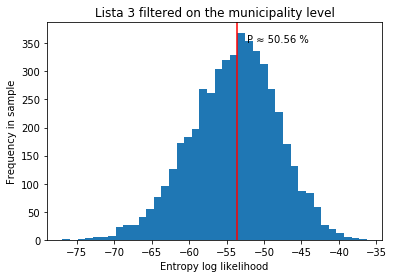

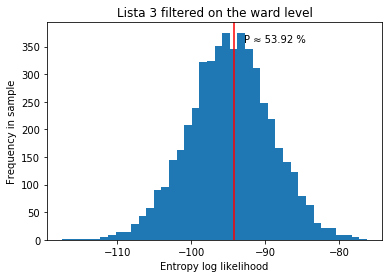

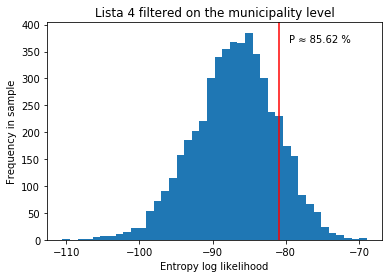

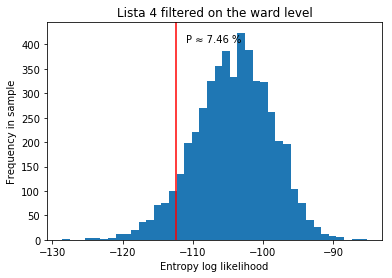

In [10]:
for lista, filtered_by in sorted(tests.keys()):
    test = tests[(lista, filtered_by)]
    drd.plot_entropy_distribution(
        actual_total_ent=test.likelihood,
        p=test.p,
        entropies=test.cdf.sample,
        title="Lista %d filtered on the %s level" % (lista, filtered_by)
    )

If there's any oddball behaviour, likely that could be relatively easily extracted from the rows defined by Lista 4's sufficiently big vote counts, compared to the other options that were considered.

# 2. Scoring and ranking

We can score and rank the area codes based on the irregularity score of the last digit sequences in the constituent groups.

It's only the Lista 4 results which are under examination here.

(This takes a while, say 3 minutes on the first run.)

In [11]:
def check_ranking(merged, info):
    feasible_df = drd.get_feasible_rows(
        merged,
        100,
        [list(merged.columns).index(info.get_lista_column(4))]
    )

    scores = drd.get_group_scores(feasible_df[info.area_column],
                                  feasible_df[info.get_lista_column(4)].values % 10,
                                  overhearing_base_columns=[
                                      feasible_df[info.valid_votes_column].values % 10,
                                      feasible_df[info.get_lista_column(4)].values % 10,
                                  ],
                                  overhearing_indep_columns=[
                                      feasible_df[info.get_lista_column(3)].values % 10,
                                  ],
                                  quiet=True  # this many messages would ruin the notebook
                                  )

    scores.sort_values(inplace=True)
    return scores

ranking = check_ranking(df, info)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecatedWarning: get_feasible_rows is deprecated as of 0.0.12 and will be removed in 0.1.0. Please use the filter and filter_df functions instead.
  """


In [12]:
ranking.head()

group_id
61801     0.000000
140605    0.000003
60101     0.000005
302306    0.000009
121113    0.000016
dtype: float64

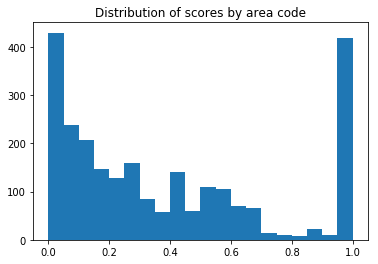

In [13]:
plt.hist(ranking, bins=20)
plt.title("Distribution of scores by area code")
plt.show()

There is apparently plenty of low score areas (these scores are derived from probabilities - so we could think of something like a proxy metric to low probability).

Let's take a look at whether there can be any systematic looking relation between irregular digit distributions and vote shares!

Note that these fingerprints are weighted by the votes received, so that we rather observe the distribution of actual votes than just what ratios were typical.
Obviously, similar silhouettes and shapes and hotpoints could still embody very different, but identically looking effects without this.

# 3. Can there be a strategy? - Plots...

Plotting the results is the next step.

Below is a rough explanation of how the - typically singular - patch on the fingerprint charts gets smeared in a handful of scenarios (the smear could be an aggregate of such a[](http://) change carried out to different degrees).

Note that the diagonal directions coincide with a "nothing else" scenario.

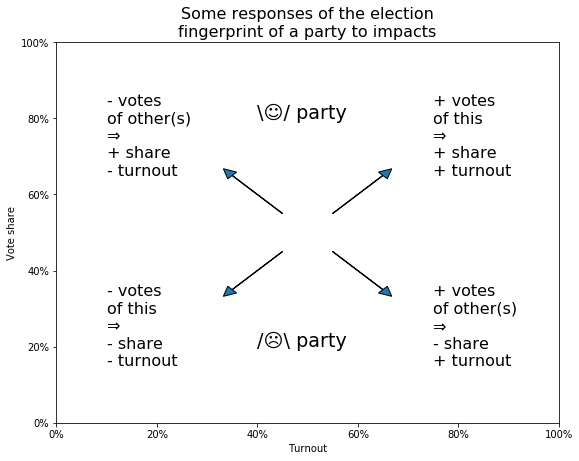

In [14]:
old_figsize = plt.rcParams["figure.figsize"]
try:
    plt.rcParams["figure.figsize"] = [9, 7]
    drd.plot_explanatory_fingerprint_responses(fontsize=16)
finally:
    plt.rcParams["figure.figsize"] = old_figsize

Now we adapt the plotting utilities to the Polish data processing, then plot electoral fingerprints - of course, a ranking is unlikely to provide a 100% perfect separation:

In [15]:
def plot_PL_fingerprint(merged, info, areas, group_desc, lista_index):
    act_df = merged[merged[info.area_column].isin(areas)]
    drd.plot_fingerprint(
        party_votes=act_df[info.get_lista_column(lista_index)],
        valid_votes=act_df[info.valid_votes_column],
        registered_voters=act_df[info.nr_of_registered_voters_column],
        title="Poland %s, 2019 EP, lista %d" %
              (group_desc, lista_index),
        quiet=False,
    )

n = len(ranking)

## Lista 4 (PiS)

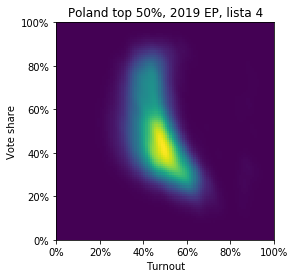

In [16]:
plot_PL_fingerprint(df, info, ranking.index[:int(n / 2)], "top 50%", 4)

Trivia: Lista 4 is spearheaded by PiS, the governing party. In 2014, PiS was organizing a protest due to the huge number of invalid votes (20%) experienced then.

Apparently, in the more suspicious areas they did less well than in the less suspicious half (versus bottom chart), as the bright patch, the majority of votes is in the bottom, "lower percentage of votes won"  half of the chart.

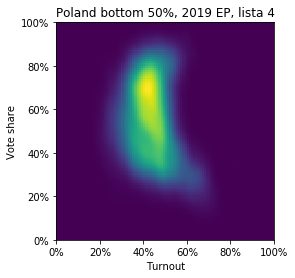

In [17]:
plot_PL_fingerprint(df, info, ranking.index[int(n / 2):], "bottom 50%", 4)

## Lista 3 (PO)

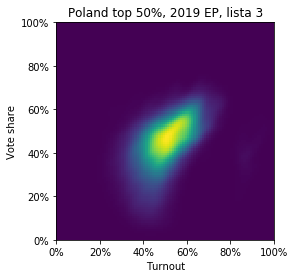

In [18]:
plot_PL_fingerprint(df, info, ranking.index[:int(n / 2)], "top 50%", 3)

Trivia: Lista 3 is spearheaded by PO, the strongest contender party. In 2014, PiS was organizing the protest due to PO's involvement in the alleged electoral fraud.

Apparently, in the more suspicious areas they did better than in the less suspicious half (= bottom chart), as the bright patch, the majority of votes shifts towards the top right, "higher turnout, higher vote share"  quarter of the top chart.

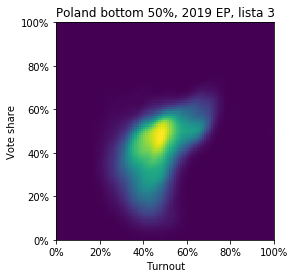

In [19]:
plot_PL_fingerprint(df, info, ranking.index[int(n / 2):], "bottom 50%", 3)

# Origins ("very optional reading")

I have primarily went on to analyse Hungarian data, which definitely looks very suspicious in some cases (esp. in my home town), and anomalies then seem to favour the notoriously winning populist party, although it's pretty unobvious at the first look.

I then tried my luck with other data sets, to see how things go elsewhere. For now, let's just say I expected to find something in Poland as well, and it does seem to look interesting.
I took the opporunity to utilize the re-applicatoion of the methods to start extracting the core of the techniques into (my first) Python package (expect cats and dogs therefore...), but it's really just the start.
There are loads of other methods and actually scientific and quality work out there (e.g. that of Peter Klimek), which could also be put into code, perhaps into the package.

If you are interested, have a look at [my summary slides of the Hungarian findings](https://docs.google.com/presentation/d/e/2PACX-1vTH7yhMRkwkEknyj2EyKBOluytggyHz0l3UlHxLxr58ao8Oy5UcsrvnVu4m_Nt--3VlxFoJ9EkvCyBs/pub?start=false&loop=false&delayms=3000) (so far).

# Conclusion

It is partly an appetizer, probably Polish data enthusiasts could do a way better job at looking at their own data. I hope some will have a look!

Likely [this very interesting map](https://www.reddit.com/r/europe/comments/7fwq02/polish_election_results_overlaid_on_a_map_of_the/) can explain a lot of the two-faced nature of the above plots, perhaps not all of it though.

Then if the above gave you no motivation, only doubt about the correctness of the approach - of course fine!

But if the above makes you already doubt the election results - also great, one practical option is to go and count votes yourself (in Hungary it is possible to apply, though can be tiresome to get there), as well as to incentivize others to do so. Or do something, you know :) Take things in your hands ...

I guess it's just generally good practice to be a bit skeptical.